In [1]:
%matplotlib inline
import numpy as np
import numba
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set("talk")
from matplotlib import rc,rcParams
from matplotlib import animation
plt.rcParams['animation.html'] = 'html5'

In [2]:
rc('text', usetex=False)
rcParams['figure.figsize'] = (12, 9)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['axes.titlesize']=20.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}']


In [25]:
u.shape

(500, 400)

In [26]:
def animate_wave(sol,xx,dt,interval=30):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_aspect("equal")
    cs,=plt.plot(xx,sol[:,0])
    plt.close()
    def animate(i):
        ax.set_title("t = {:.1f}s".format(dt*i), y=1.1)
        cs.set_data(xx,sol[:,i])
        return (cs,)
    return animation.FuncAnimation(fig, animate, frames=sol.shape[1], interval=interval, blit=True)

## Μονοδιάστατη Γραμμική εξίσωση Μεταφοράς (1D linear convection equation)
Η *μονοδιάστατη εξίσωση μεταφοράς* είναι το πιο απλό παράδειγμα αριθμητικής επίλυσης μερικών διαφορικών εξισώσεων. 

\begin{equation}\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0\end{equation}

Η εξίσωση αυτή αντιπροσωπεύει ένα *κύμα* που κινείται με ταχύτητα $c$ στη κατεύθυνση $x$.

Για αρχικές συνθήκες με $u(x,0)=u_0(x)$, η εξίσωση έχει τη λύση D' Alembert:

\begin{equation}
u(x,t)=u_0(x-ct). 
\end{equation}

Go on: check it. Take the time and space derivative and stick them into the equation to see that it holds!

Από τη λύση παρατηρούμε ότι: 

1. Το σχήμα δεν αλλάζει αλλα διατηρεί την αρχική διαταραχή, $u_0$, μετακινημένη στη $x$-καταεύθυνση 
2. Είναι σταθερή πάνω στις **χαρακτηριστικές καμπύλες**, $x-ct=$constant. Αυτό σημαίνει οτί για κάθε σημείο στο χώρο και το χρόνο μπορείς να κινηθεί πάνω στη χαρακτηριστική καμπύλη και να βρείς τη λύση για $t=0$.

![characteristics](figures/characteristics.png)


## Πεπερασμένες Διαφορές (Finite-Differences)
Σε σύγκριση με τις συνήθεις διαφορικές εξιώσεις όπου κυρίως είχαμε παραγώγους στο χρόνο, τώρα έχουμε παραγώγους και στο χώρο και στο χρόνο. Για να επιλύσουμε αριθμητικά αυτές τις δύο θα πρέπει να διακριτοποιήσουμε και το χώρο και το χρόνο.

\begin{matrix}
t^{n+1} & \rightarrow & \bullet  && \bullet  && \bullet  \\
t^n & \rightarrow & \bullet  && \bullet  && \bullet  \\
& &  x_{i-1} && x_i && x_{i+1}
\end{matrix}

Σύμφωνα με τη παραπάνω διακριτοποιήση η αριθμητική λύση της $u(x,t)$ θα δίνεται σαν $u^n_i$ όπου ο δείξτης πάνω μας δείχνει τη χρονική διακριτοποίηση και ο κάτων τη χωρική

\begin{matrix}
& &\bullet & & \bullet & &  \bullet \\
& &u^{n+1}_{i-1} & & u^{n+1}_i & & u^{n+1}_{i+1} \\
& &\bullet & & \bullet & &  \bullet \\
& &u^n_{i-1} & & u^n_i & & u^n_{i+1} \\
& &\bullet & & \bullet & &  \bullet \\
& &u^{n-1}_{i-1} & & u^{n-1}_i & & u^{n-1}_{i+1} \\
\end{matrix}


### Διακριτοποιήση της εξίωσωσης μεταφοράς
Θα διακριτοποιήσουμε την εξίσωση μεταφοράς στο χώρο και στο χρόνο.
Η χωρική συντεταγμένη $x$ θα μετατραπεί σε ένα μονοδιάστατο πίνακα μεγέθους $N=(x_{max}-x_{min})/dx$.
Από τον ορισμό της παραγώγου:

\begin{equation}\frac{\partial u}{\partial x}\approx \frac{u(x+dx)-u(x)}{dx}\end{equation}

Η σχέση αυτή μπορεί να εφαρμοστεί σε κάθε σημείο $x_i$ χωρίς όμως να είναι ο αποκλειστικός τρόπος για να γράψουμε τη παραάγωγο. Η γεωμετρική ερμηνεία της πρώτης παραγώγου $\partial u/ \partial x$ σε κάθε σημείο είναι οτι αντιπροσωπεύει τη κλίση της εφαπτωμένης στη καμπύλη $u(x)$. Στο παρακάτω γράφημε βλέπουμε τρείς πιθανόυς τρόπους που μπορούμε να υπολογίσουμε τη κλιση αυτή χρησιμοποιώντας τις διακριτοποιημένες τιμές της $x_i,u_i$ και την απόκλιση από τη πραγματική παράγωγο. 

![FDapproxiamtions](figures/FDapproxiamtions.png)
#### Three finite-difference approximations at $x_i$.

Οι τρείς αυτοί τρόποι υπολογισμού της $\partial u/ \partial x$ είναι οι εξής:

* Forward difference: μέσω της $x_i$ και της $x_i + d x$,
* Backward difference: μέσω της $x_i$ και $x_i- d x$,
* Central difference: με τη χρήση δύο σημείων δεξιά και αριστερά του $x_i$.

άρα:

\begin{eqnarray}
\frac{\partial u}{\partial x} & \approx & \frac{u(x_{i+1})-u(x_i)}{\Delta x} \quad\text{Forward}\\
\frac{\partial u}{\partial x} & \approx & \frac{u(x_i)-u(x_{i-1})}{\Delta x} \quad\text{Backward}\\
\frac{\partial u}{\partial x} & \approx & \frac{u(x_{i+1})-u(x_{i-1})}{2\Delta x} \quad\text{Central}
\end{eqnarray}

Αν χρησιμοποιήσουμε την forward-difference (μέθοδος Euler) για τη χρονική παράγωγο και τη backward-difference για τη χωρική έχουμε:

\begin{equation}\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0, \end{equation}

με $n$ και $n+1$ δύο διαδοχικές χρονικές στιγμες και $i-1$, $i$ δύο γειτονικά σημεία. Δεδομένου των αρχικών τιμών η λύση για το σημείο $u_i^{n+1}$ θα είναι:  

\begin{equation}u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)\end{equation}

Μπορούμε να αποτυπώσουμε σε μορφή γράφου (**stencil**) το τρόπο που υπολογίζουμε τις λύσεις. 
![FTBS_stencil](figures/FTBS_stencil.png)
#### Stencil for the "forward-time/backward-space" scheme.

In [4]:
c = 1. #wave velocity
xmin=0.; xmax=5. #1d xwrio
t0=0.; tmax=4. #xroniko diastima
dx=0.01 #bima sto xwrο
dt=0.01 #bima sto xrono
xx = np.arange(xmin,xmax,dx) #pinakas me ta x_i
tt = np.arange(t0,tmax,dt) #pinakas me ta t^n

### Εφαρμογή μέσω της Python
Για την καταγραφή της λύσης θα δημιουργήσουμε έναν δισδιάστατο πίνακα όπου θα αποτυπώνουμε τη λύση στο χώρο και στο χρόνο. Η κάθε γραμμή στο πίνακα αυτό θα αποτυπώνει μια συγκεκριμένη χρονική στιγμή $t^n = tt[n]$ και κάθε στήλη ένα συγκεκριμένο σημείο $x_i=xx[i]$

In [5]:
u = np.ones((xx.shape[0],tt.shape[0])) #dimiourgia tou 2d pinaka 
u[(xx>0.3) & (xx<0.5),:]=2. # arxikes times (tetragwnikos palmos)

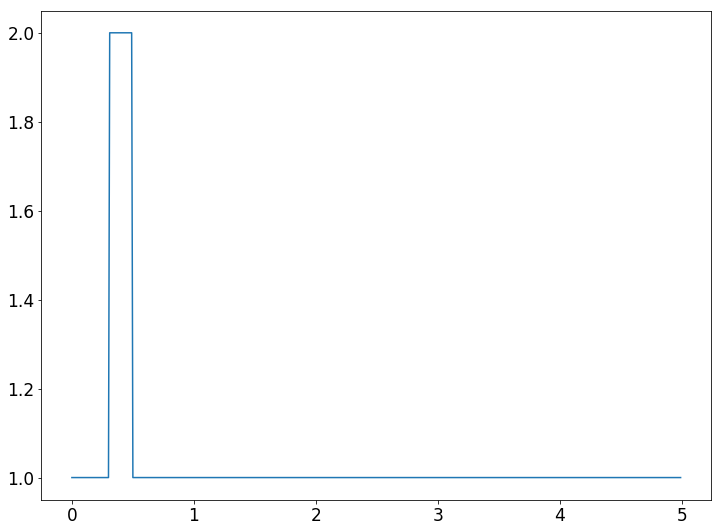

In [6]:
plt.plot(xx,u[:,0])

In [7]:
for n,t in enumerate(tt[1:]):
    for i,x in enumerate(xx[1:]):
        u[i,n] = u[i,n-1]-c*dt/dx*(u[i,n-1]-u[i-1,n-1])

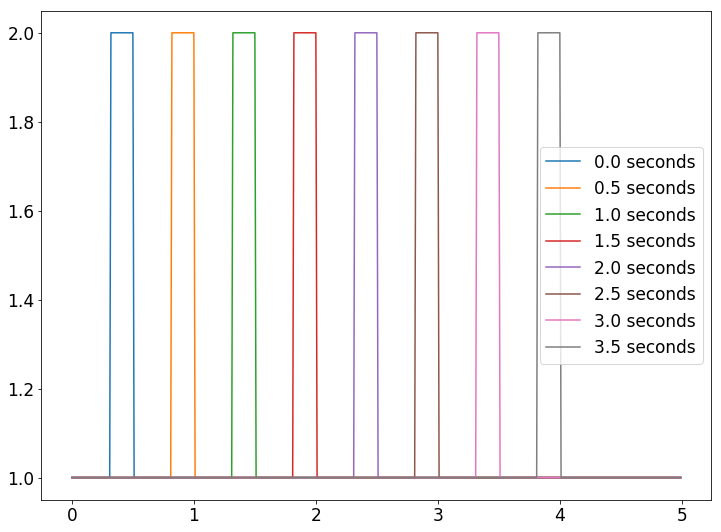

In [8]:
for n in np.linspace(0,tt.shape[0],num=8,dtype=int,endpoint=False):
    plt.plot(xx,u[:,n],label='{:.3} seconds'.format(tt[n]))
plt.legend()

In [9]:
animate_wave(u,dt)

### Τι γίνεται αν αλλάξουμε τη ταχύτητα διάδοσης του κύματος


In [27]:
def wave_sol(c,dx=0.01,dt=0.01,L=2.,T=2.,N=6,animation=False):
    print('Cοurant Number = {:.3}'.format(c*dt/dx))
    print('Diffusion rate = {:.2}'.format(c*dx*(1.-c*dt/dx)/2))
    xmin=0.; xmax=L #1d xwrio
    t0=0.; tmax=T #xroniko diastima
    xx = np.arange(xmin,xmax,dx) #pinakas me ta x_i
    tt = np.arange(t0,tmax,dt) #pinakas me ta t^n
    u = np.ones((xx.shape[0],tt.shape[0])) #dimiourgia tou 2d pinaka 
    u[(xx>0.3) & (xx<0.5),:]=2. # arxikes times (tetragwnikos palmos)
    for n,t in enumerate(tt[1:]):
        for i,x in enumerate(xx[1:]):
            u[i,n] = u[i,n-1]-c*dt/dx*(u[i,n-1]-u[i-1,n-1])
    for n in np.linspace(0,tt.shape[0],num=N,dtype=int,endpoint=False):
        plt.plot(xx,u[:,n],label='{:.3} seconds'.format(tt[n]))
    plt.legend()
    if animation: animate_wave(u,xx,dt)

Cοurant Number = 0.1
Diffusion rate = 0.00045


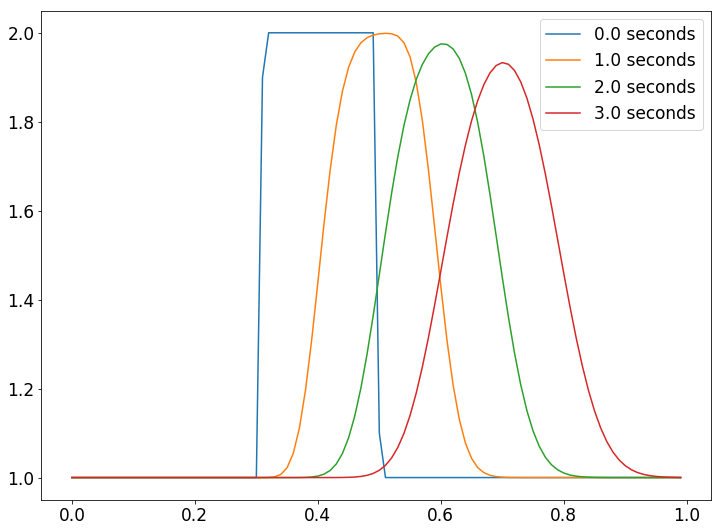

In [12]:
wave_sol(0.1,L=1.,T=4.,N=4)

τι συμβαίνει εδω?

αν αναπτύξουμε κατα Taylor τα διαφορικά:

\begin{equation} 
\frac{u(x+d x)-u(x)}{d x} =  \frac{\partial u}{\partial x} + \frac{\partial^2 u}{\partial x^2} \frac{dx}{2}
+\mathcal{O}(dx^2)
\end{equation}
άρα
\begin{equation} 
\frac{u(x)-u(x-dx)}{d x} =  \frac{\partial u}{\partial x} - \frac{\partial^2 u}{\partial x^2} \frac{dx}{2}
+\mathcal{O}(dx^2)
\end{equation}
και αντιστοιχα για το χρόνο
\begin{equation} 
\frac{u(t+dt)-u(t)}{dt} =  \frac{\partial u}{\partial t} + \frac{\partial^2 u}{\partial t^2} \frac{dt}{2}+
+\mathcal{O}(dt^2)
\end{equation}

άρα για την εξίσωση μεταφοράς

\begin{equation}\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0\end{equation}
αναπτύσουμε σε
\begin{equation} 
\frac{u^{n+1}_i-u^n_i}{dt}+ c \frac{u^{n}_i-u^n_{i-1}}{dt} - u_{tt}
\frac{dt}{2} +c u_{xx} \frac{dx}{2} +\mathcal{O}(dt^2,dx^2) = 0
\end{equation}

Ο όρος σφάλματος πρώτης τάξης 
\begin{equation} 
\mathcal{E}=\frac{1}{2} \big( c\,dx\, u_{xx} -dt \,u_{tt}\big) = \frac{1}{2} \big( c\,dx\, u_{xx} -c\, \sigma \,dx \,u_{xx}\big) = c\frac{u_{xx}}{2}\big( 1-\sigma\big) dx
\end{equation}

όπου $\sigma=\frac{cdt}{dx}$ ο αριθμός Courant.

Παρατηρούμε λοιπόν πως για αριθμό Courant διάφορο της μονάδας η λύση παρουσιάζει μια τεχνητή διάχυση με συντελεστή διάχυσης $c\frac{1-\sigma}{2} dx$

Cοurant Number = 0.91
Diffusion rate = 5e-06


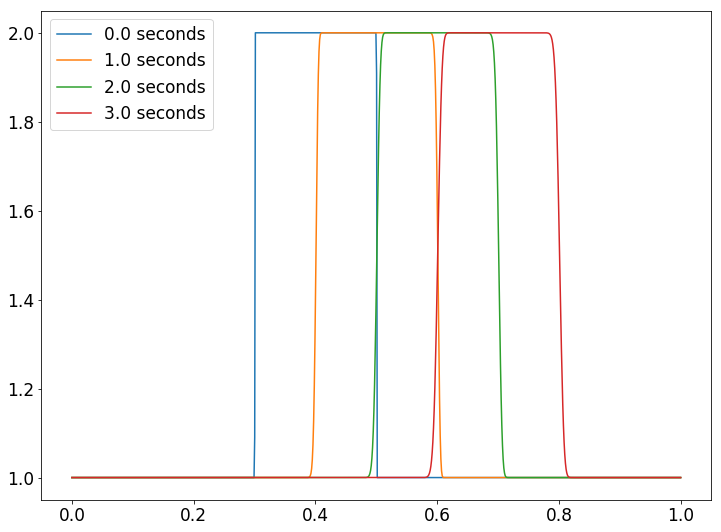

In [9]:
wave_sol(0.1,dx=0.0011,L=1.,T=4.,N=4)

Cοurant Number = 1.02
Diffusion rate = -0.0001


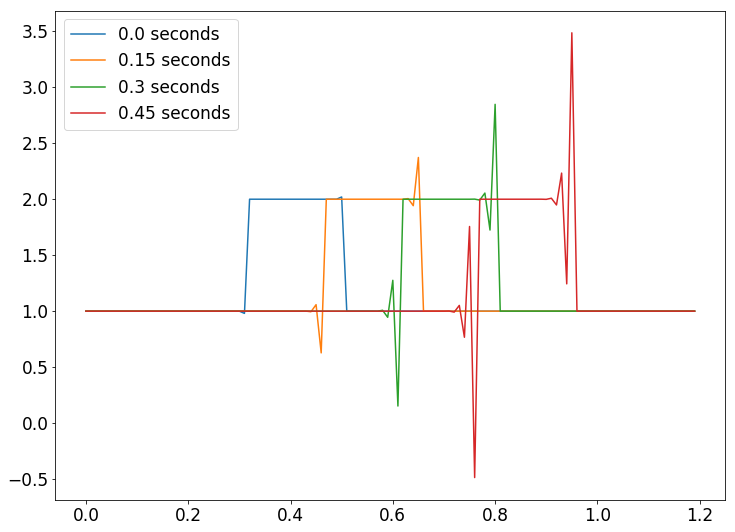

In [31]:
wave_sol(1.02,T=0.6,L=1.2,N=4)

Τώρα η λύση μας έχει εκτοξευτεί. Καθώς σε κάθε χρονικό βήμα $dt$ το κύμα ταξιδεύει απόσταση μεγαλύτερη από $dx$ οπότε η λύση έγινε *ασταθής*

![CFLcondition](figures/CFLcondition.png)
#### Graphical interpretation of the CFL condition.

το πράσινο τρίγωνο απεικονίζει τα σημεία εκείνα από τα οποία εξαρτάται η λύση στο βήμα $n+1$
Όταν η απόσταση $c dt$ γίνει μικρότερη από $dx$ τότε η χαρακτηριστική ευθεία καταλήγει στα χωρικά σημεία απο $i-1$ έως $i$. Στην αντίθετη περίπτωση η πληροφορία δεν μπορεί να μεταφερθεί, οπότε και η λύσ ειναι ασταθής.\

Έτσι καταλήγουμε στην συνθήκη CFL:

\begin{equation}\sigma = \frac{c \Delta t}{\Delta x} \leq 1 
\end{equation}

As can be proven formally, stability of the numerical solution requires that step size `dt` is calculated with respect to the size of `dx` to satisfy the condition above.  

The value of $c\Delta t/\Delta x$ is called the **Courant-Friedrichs-Lewy number** (CFL number), often denoted by $\sigma$. The value $\sigma_{\text{max}}$ that will ensure stability depends on the discretization used; for the forward-time/backward-space scheme, the condition for stability is $\sigma<1$.

In a new version of our code—written _defensively_—, we'll use the CFL number to calculate the appropriate time-step `dt` depending on the size of `dx`.  
 

## Spatial truncation error
Recall the finite-difference approximation we are using for the spatial derivative:

\begin{equation}\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}\end{equation}

We obtain it by using the definition of the derivative at a point, and simply removing the limit, in the assumption that $\Delta x$ is very small. But we already learned with Euler's method that this introduces an error, called the *truncation error*.

Using a Taylor series expansion for the spatial terms now, we see that the backward-difference scheme produces a first-order method, in space.

\begin{equation}
\frac{\partial u}{\partial x}(x_i) = \frac{u(x_i)-u(x_{i-1})}{\Delta x} + \frac{\Delta x}{2} \frac{\partial^2 u}{\partial x^2}(x_i) - \frac{\Delta x^2}{6} \frac{\partial^3 u}{\partial x^3}(x_i)+ \cdots
\end{equation}

The dominant term that is neglected in the finite-difference approximation is of $\mathcal{O}(\Delta x)$. We also see that the approximation *converges* to the exact derivative as $\Delta x \rightarrow 0$. That's good news!

In summary, the chosen "forward-time/backward space" difference scheme is first-order in both space and time: the truncation errors are $\mathcal{O}(\Delta t, \Delta x)$. We'll come back to this!

## Non-linear convection
Let's move on to the non-linear convection equation, using the same methods as before. The 1-D convection equation is:

\begin{equation}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0\end{equation}

The only difference with the linear case is that we've replaced the constant wave speed $c$ by the variable speed $u$. The equation is non-linear because now we have a product of the solution and one of its derivatives: the product $u\,\partial u/\partial x$. This changes everything!

We're going to use the same discretization as for linear convection: forward difference in time and backward difference in space. Here is the discretized equation:

\begin{equation}\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n-u_{i-1}^n}{\Delta x} = 0\end{equation}

Solving for the only unknown term, $u_i^{n+1}$, gives an equation that can be used to advance in time:

\begin{equation}u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n)\end{equation}

There is very little that needs to change from the code written so far. In fact, we'll even use the same square-wave initial condition. But let's re-initialize the variable `u` with the initial values, and re-enter the numerical parameters here, for convenience (we no longer need $c$, though).

![vectorizedstencil](figures/numpy_stensil.png)

<br>
#### Sketch to explain vectorized stencil operation.  Adapted from ["Indices point between elements"](https://blog.nelhage.com/2015/08/indices-point-between-elements/) by Nelson Elhage.  


In [322]:
xmin=0.; xmax=2.
t0=0.; tmax=2.
dx=0.01
sigma = .3
dt=sigma*dx
xx = np.arange(xmin,xmax,dx)
tt = np.arange(t0,tmax,dt)
u = np.ones((xx.shape[0],tt.shape[0]))#numpy function ones()
u[(xx>0.3) & (xx<0.5),:]=2.
for it,t in enumerate(tt[1:]):
    #or ix,x in enumerate(xx[1:]):
    #   u[ix,it] = u[ix,it-1]-u[ix,it-1]*dt/dx*(u[ix,it-1]-u[ix-1,it-1])
    u[1:,it]=u[1:,it-1]-u[1:,it-1]*dt/dx*(u[1:,it-1]-u[0:-1,it-1])

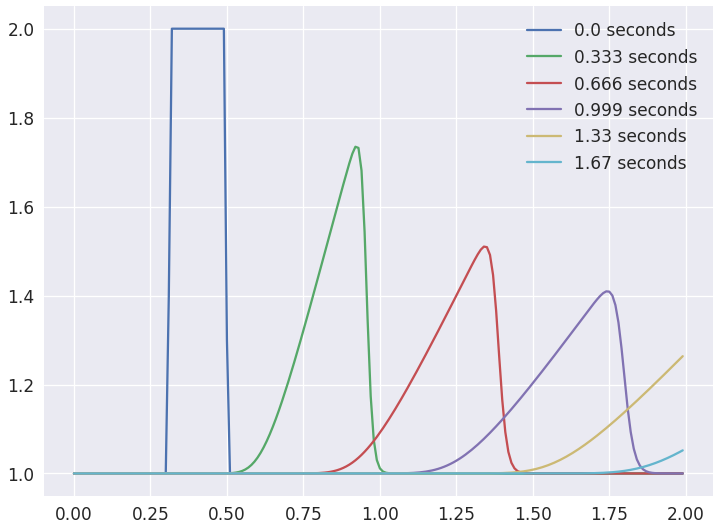

In [323]:
for it in np.linspace(0,tt.shape[0],num=6,dtype=int,endpoint=False):
    plt.plot(xx,u[:,it],label='{:.3} seconds'.format(tt[it]))
plt.legend()

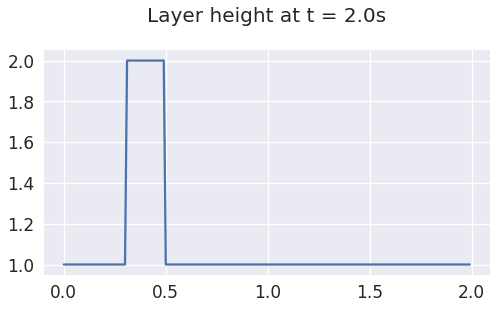

In [324]:
animate_wave(u)

## 1-D Diffusion
Welcome back! This is the third IPython Notebook of the series *Space and Time — Introduction of Finite-difference solutions of PDEs*, the second module of ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about). 

In the previous IPython notebooks of this series, we studied the numerical solution of the linear and non-linear convection equations using the finite-difference method, and learned about the CFL condition. Now, we will look at the one-dimensional diffusion equation:

\begin{equation}\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}\end{equation}

where $\nu$ is a constant known as the *diffusion coefficient*.

The first thing you should notice is that this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing 2nd-order derivatives
The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of forward difference and backward difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)$

If we add these two expansions, the odd-numbered derivatives will cancel out.  Neglecting any terms of ${\mathcal O}(\Delta x^4)$ or higher (and really, those are very small), we can rearrange the sum of these two expansions to solve for the second-derivative.  

$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\big|_i + {\mathcal O}(\Delta x^4)$

And finally:

\begin{equation}\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + {\mathcal O}(\Delta x^2)\end{equation}

The central difference approximation of the 2nd-order derivative is 2nd-order accurate.

### Back to diffusion
We can now write the discretized version of the diffusion equation in 1D:

\begin{equation}\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}\end{equation}

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation to isolate this term:

\begin{equation}u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})\end{equation}

This discrete equation allows us to write a program that advances a solution in time—but we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else.

### Stability of the diffusion equation
The diffusion equation is not free of stability constraints. Just like the linear and non-linear convection equations, there are a set of discretization parameters $\Delta x$ and $\Delta t$ that will make the numerical solution blow up. For the diffusion equation and the discretization used here, the stability condition for diffusion is

$$
\begin{equation}
\nu \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{equation}
$$

In [350]:
xmin=0.; xmax=2.
t0=0.; tmax=0.2
nu=0.3
dx=0.04
sigma = .15
dt=nu*sigma*dx**2
xx = np.arange(xmin,xmax,dx)
tt = np.arange(t0,tmax,dt)
u = np.ones((xx.shape[0],tt.shape[0]))#numpy function ones()
u[(xx>0.95) & (xx<1.05),:]=2.
for it,t in enumerate(tt[1:]):
    u[1:-1,it]=u[1:-1,it-1]+nu*dt/dx**2 *(u[2:,it-1]-2.*u[1:-1,it-1]+u[:-2,it-1])

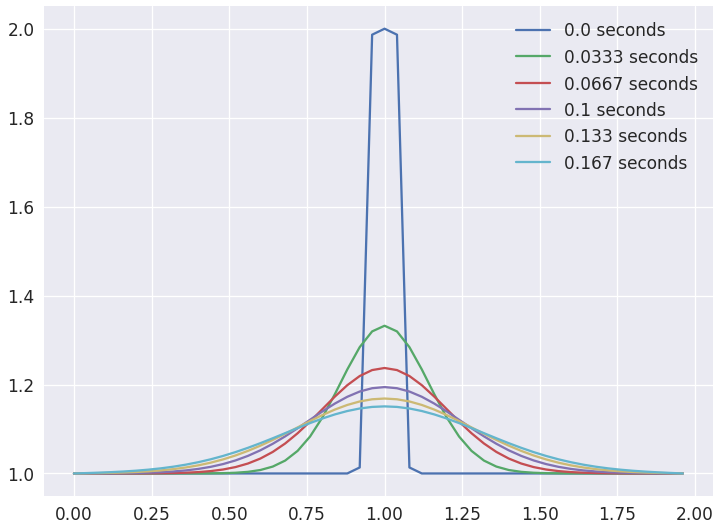

In [351]:
for it in np.linspace(0,tt.shape[0],num=6,dtype=int,endpoint=False):
    plt.plot(xx,u[:,it],label='{:.3} seconds'.format(tt[it]))
plt.legend()

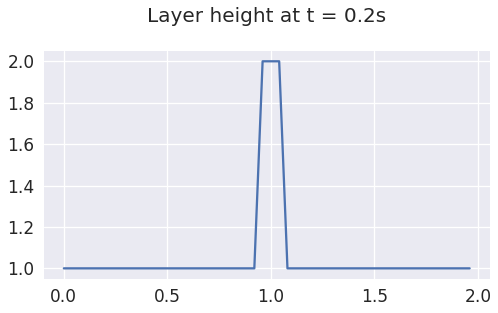

In [352]:
def animate_wave(sol):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_aspect("equal")
    cs,=ax.plot(xx,sol[:,0])
    
    def animate(i):
        ax.set_title("Layer height at t = {:.1f}s".format(dt*i), y=1.1)
        cs.set_data(xx,sol[:,i])
        return (cs,)
    return animation.FuncAnimation(fig, animate, frames=sol.shape[1], interval=30, blit=True)

animate_wave(u)

## Conservation laws
You know from (non relativistic) physics that mass is _conserved_. This is one example of a conserved quantity, but there are others (like momentum and energy) and they all obey a _conservation law_. Let's start with the more intuitive case of conservation of mass.
### Conservation of mass
In any closed system, we know that the mass $M$ in the system does not change, which we can write: $\frac{D\,M}{Dt} =0$. When we change the point of view from a closed system to what engineers call a _control volume_, mass can move in and out of the volume and conservation of mass is now expressed by:

![massconservation-CV](./figures/massconservation-CV.png)

Let's imagine the control volume as a tiny cylinder of cross-section dA and length dx, like in the sketch below.

![1Dcontrolvolume](./figures/1Dcontrolvolume.png)
#### Figure 1. Tiny control volume in the shape of a cylinder.

If we represent the mass density by $\rho$, then mass is equal to $\rho\times$ volume. For simplicity, let's assume that mass flows in or out of the control volume only in one direction, say, the $x$-direction. Express the 1D velocity component by $u$, and conservation of mass for the control volume is translated to a mathematical expression as follows:

\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}\rho \, dV + \int_{\text{cs}}\rho \, u\, dA =0
\end{equation}

where "cv" stands for control volume and "cs" stands for control surface. The first term represents the rate of change of mass in the control volume, and the second term is the rate of flow of mass, with velocity $u$, accross the control surface.

Since the control volume is very small, we can take, to leading order, $\rho$ as a uniform quantity inside it, and the first term in equation (1) can be simplified to the time derivative of density multiplied by the volume of the tiny cylinder, $dAdx$:

$$\frac{\partial}{\partial t}\int_{\text{cv}}\rho \, dV \rightarrow \frac{\partial \rho}{\partial t} dAdx$$

Now, for the second term in equation (1), we have to do a little more work. The quantity inside the integral is now $\rho u$ and, to leading order, we have to take into consideration that this quantity can change in the distance $dx$. Take $\rho u$ to be the value in the center of the cylinder. Then the flow of mass on each side is illustrated in the figure below, where we use a Taylor expansion of the quantity $\rho u$ around the center of the control volume (to first order).

![1Dfluxbalance](./figures/1Dfluxbalance.png)
#### Figure 2. Flux terms on the control surfaces.

Subtracting the negative flux on the left to the positive flux on the right, we arrive at the total flux of mass accross the control surfaces, the second term in equation (1):

$$ \int_{\text{cs}}\rho \, u\, dA \rightarrow \frac{\partial}{\partial x}(\rho u) dAdx$$

We can now put together the equation of conservation of mass for the tiny cylindrical control volume, which after diving by $dAdx$ is:

\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u)=0
\end{equation}

This is the 1D mass conservation equation in differential form. If we take $u$ to be a constant and take it out of the spatial derivative this equation looks the same as the first PDE we studied: the linear convection equation in [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb).
But in the form shown above, it is a typical _conservation law_. The term under the spatial derivative is called the _flux_, for reasons that should be clear from our discussion above: it represents amounts of the conserved quantity flowing across the boundary of the control volume.

### General conservation laws
All conservation laws express the same idea: the variation of a conserved quantity inside a control volume is due to the total flux of that quantity crossing the boundary surface (plus possibly the effect of any sources inside the volume, but let's ignore those for now).

The _flux_ is a fundamental concept in conservation laws: it represents the amount of the quantity that crosses a surface per unit time. Our discussion above was limited to flow in one dimension, but in general the flux has any direction and is a vector quantity. Think about this: if the direction of flow is parallel to the surface, then no quantity comes in or out. We really only care about the component of flux perpendicular to the surface. Mathematically, for a vector flux $\vec{F}$, the amount of the conserved quantity crossing a small surface element is:

$$\vec{F}\cdot d\vec{A}$$

where $d\vec{A}$ points in the direction of the outward normal to the surface. A general conservation law for a quantity $e$ is thus (still ignoring possible sources):

\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}e \, dV + \oint_{\text{cs}}\vec{F}\cdot d\vec{A} =0
\end{equation}

To obtain a differential form of this conservation equation, we can apply the theorem of Gauss to the second integral, which brings the gradient of $\vec{F}$ into play. One way to recognize a conservation law in differential form is that the _fluxes appear only under the gradient operator_.

Recall the non-linear convection equation from [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb). It was:

\begin{equation}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0\end{equation}

If we look closely at the spatial derivative, we can rewrite this equation as

\begin{equation}\frac{\partial u}{\partial t} + \frac{\partial}{\partial x} \left(\frac{u^2}{2} \right) = 0, \end{equation}

which is the *conservation form* of the non-linear convection equation, with flux $F=\frac{u^2}{2}$.
## Traffic flow model
We've all experienced it: as rush hour approaches certain roads in or out of city centers start getting full of cars, and the speed of travel can reduce to a crawl. Sometimes, the cars stop altogether. If you're a driver, you know that the more cars on the road, the slower your trip will flow.

Traffic flow models seek to describe these everyday experiences with mathematics, to help engineers design better road systems.

Let's review the [Lighthill-Whitham-Richards](http://en.wikipedia.org/wiki/Macroscopic_traffic_flow_model) traffic model that was offered as an exercise at the end of Module 2. This model considers cars with a continuous *traffic density* (average number of cars per unit length of road) rather than keeping track of them individually. If $\rho(x)=0$, there are no cars at that point $x$ of the road.  If $\rho(x) = \rho_{\rm max}$, traffic is literally bumper to bumper.

If the number of cars on a bounded stretch of road changes, it means that cars are entering or leaving the road somehow. _Traffic density obeys a conservation law_ (!) where the flux is the number of cars leaving the road per unit time. It is given by $F=\rho u$—as with mass conservation, flux equals density times velocity. But don't forget your experience on the road: the speed of travel depends on the car density. Here, $u$ refers not to the speed of each individual car, but to the _traffic speed_ at a given point of the road.  

You know from experience that with more cars on the road, the speed of travel decreases. It is also true that if you are traveling at fast speed, you are advised to leave a larger gap with cars ahead. These two considerations lead us to propose a monotonically decreasing $u=u(\rho)$ function. As a first approximation, we may consider the linear function:

\begin{equation}u(\rho) = u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)\end{equation}

![velocityvsdensity](./figures/velocityvsdensity.png)
#### Figure 3. Traffic speed vs. traffic density.

The linear model of the behavior of drivers satisfies these experimental observations:  
1.  All drivers will approach a maximum velocity $u_{max}$ when the road is empty.
2.  If the road is completely jampacked ($\rho \rightarrow \rho_{max}$), velocity goes to zero.  

That seems like a reasonable approximation of reality! 

Applying a conservation law to the vehicle traffic, the traffic density will obey the following transport equation:

\begin{equation} \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0 \end{equation}

where $F$ is the *traffic flux*, which in the linear traffic-speed model is given by: 

\begin{equation} F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right).
\end{equation}

We can now use our numerical kung-fu to solve some interesting traffic situations, and check if our simple model gives realistic results!

### Green light!
Let's say that we are examining a road of length $4$ where the speed limit is $u_{\rm max}=1$, fitting $10$ cars per unit length $(\rho_{\rm max}=10)$. Now, imagine we have an intersection with a red light at $x=2$.  At the stoplight, traffic is bumper-to-bumper, and the traffic density decreases linearly to zero as we approach the beginning of our road. Ahead of the stoplight, the road is clear.

Mathematically, we can represent this situation with the following initial condition:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
\rho_{\rm max}\frac{x}{2} & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

Let's see what a plot of that looks like.


In [248]:
def animate_shallow_water(sol):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.set_xlim((xx.min(),xx.max()))
    ax.set_ylim((yy.min(),yy.max()))
    cs = plt.pcolormesh(xx,yy,sol[0],vmin=9.9,vmax=10.1,cmap="RdBu_r")
    plt.colorbar(cs,orientation="horizontal")
    plt.close()

    def animate(i):
        ax.set_title("Layer height at t = {:.1f}s".format(dt*i), y=1.1)
        cs.set_array(sol[i][:-1,:-1].flatten())
        return (cs,)

    return animation.FuncAnimation(fig, animate, frames=len(sol), interval=20, blit=True)

In [2]:
yy, xx = np.mgrid[-50:50:100j,-100:100:100j].astype(float)
dx = xx[0,1] - xx[0,0]
dy = yy[1,0] - yy[0,0]

d = 10
g = 9.81
dt = 0.5 * min(dx,dy) / np.sqrt(g*d)
t1 = 10
eps = 0.1

h0 = d + np.exp(-(xx**2 + yy**2)/20)
u0 = np.zeros_like(xx)
v0 = np.zeros_like(xx)

In [3]:
def iterate_py(h,u,v):
    h_new = np.zeros_like(h)
    u_new = np.zeros_like(u)
    v_new = np.zeros_like(v)
    
    n1, n2 = h.shape
    for i in range(n1):
        for j in range(n2):
            if j == n2-1:
                u_new[i,j] = 0
            else:
                u_new[i,j] = u[i,j] - g*dt/dx * (h[i,j+1] - h[i,j])
            if i == n1-1:
                v_new[i,j] = 0
            else:
                v_new[i,j] = v[i,j] - g*dt/dy * (h[i+1,j] - h[i,j])
                
    u_plus = .5 * (u_new + np.abs(u_new))
    u_minus = .5 * (u_new - np.abs(u_new))
    v_plus = .5 * (v_new + np.abs(v_new))
    v_minus = .5 * (v_new - np.abs(v_new))
    
    for i in range(n1):
        for j in range(n2):
            if j == n2-1:
                f_e = 0
            else:
                f_e = u_plus[i,j] * h[i,j] + u_minus[i,j] * h[i,j+1]
            if i == n1-1:
                f_n = 0
            else:
                f_n = v_plus[i,j] * h[i,j] + v_minus[i,j] * h[i+1,j]
            if j == 0:
                f_w = 0
            else:
                f_w = u_plus[i,j-1] * h[i,j-1] + u_minus[i,j-1] * h[i,j]
            if i == 0:
                f_s = 0
            else:
                f_s = v_plus[i-1,j] * h[i-1,j] + v_minus[i-1,j] * h[i,j]           
            h_new[i,j] = h[i,j] - dt/dx*(f_e - f_w) - dt/dy*(f_n - f_s)
    
    h_filter = np.zeros_like(h_new)
    for i in range(n1):
        for j in range(n2):
            if j == n2-1:
                h_e = h_new[i,j-1]
            else:
                h_e = h_new[i,j+1]
            if i == n1-1:
                h_n = h_new[i-1,j]
            else:
                h_n = h_new[i+1,j]
            if j == 0:
                h_w = h_new[i,j+1]
            else:
                h_w = h_new[i,j-1]
            if i == 0:
                h_s = h_new[i+1,j]
            else:
                h_s = h_new[i-1,j]
            h_filter[i,j] = (1-eps) * h_new[i,j] + .25*eps*(h_e+h_n+h_w+h_s)
            
    return h_filter, u_new, v_new

In [ ]:
np.pad

In [7]:
def iterate_numpy(h,u,v):
    h_pad = np.pad(h,1,"edge")
    
    u_new = u - g*dt/dx * (h_pad[1:-1,2:] - h)
    v_new = v - g*dt/dy * (h_pad[2:,1:-1] - h)
    
    u_new_pad = np.pad(u_new,1,"constant")
    v_new_pad = np.pad(v_new,1,"constant")
                
    u_plus = .5 * (u_new_pad + np.abs(u_new_pad))
    u_minus = .5 * (u_new_pad - np.abs(u_new_pad))
    v_plus = .5 * (v_new_pad + np.abs(v_new_pad))
    v_minus = .5 * (v_new_pad - np.abs(v_new_pad))
    
    f_e = u_plus[1:-1,1:-1] * h + u_minus[1:-1,1:-1] * h_pad[1:-1,2:]
    f_n = v_plus[1:-1,1:-1] * h + v_minus[1:-1,1:-1] * h_pad[2:,1:-1]
    f_w = u_plus[1:-1,:-2] * h_pad[1:-1,:-2] + u_minus[1:-1,:-2] * h
    f_s = v_plus[:-2,1:-1] * h_pad[:-2,1:-1] + v_minus[:-2,1:-1] * h
         
    h_new = h - dt/dx*(f_e - f_w) - dt/dy*(f_n - f_s)
    h_new_pad = np.pad(h,1,"reflect")
    h_filter = (1-eps) * h_new + .25*eps*(h_new_pad[:-2,1:-1]+h_new_pad[1:-1,:-2]+\
                                          h_new_pad[2:,1:-1]+h_new_pad[1:-1,2:])
    return h_filter, u_new, v_new

In [15]:
@numba.jit
def iterate_numba(h,u,v):
    h_pad = np.pad(h,1,"edge")
    
    u_new = u - g*dt/dx * (h_pad[1:-1,2:] - h)
    v_new = v - g*dt/dy * (h_pad[2:,1:-1] - h)
    
    u_new_pad = np.pad(u_new,1,"constant")
    v_new_pad = np.pad(v_new,1,"constant")
                
    u_plus = .5 * (u_new_pad + np.abs(u_new_pad))
    u_minus = .5 * (u_new_pad - np.abs(u_new_pad))
    v_plus = .5 * (v_new_pad + np.abs(v_new_pad))
    v_minus = .5 * (v_new_pad - np.abs(v_new_pad))
    
    f_e = u_plus[1:-1,1:-1] * h + u_minus[1:-1,1:-1] * h_pad[1:-1,2:]
    f_n = v_plus[1:-1,1:-1] * h + v_minus[1:-1,1:-1] * h_pad[2:,1:-1]
    f_w = u_plus[1:-1,:-2] * h_pad[1:-1,:-2] + u_minus[1:-1,:-2] * h
    f_s = v_plus[:-2,1:-1] * h_pad[:-2,1:-1] + v_minus[:-2,1:-1] * h
         
    h_new = h - dt/dx*(f_e - f_w) - dt/dy*(f_n - f_s)
    h_new_pad = np.pad(h,1,"reflect")
    h_filter = (1-eps) * h_new + .25*eps*(h_new_pad[:-2,1:-1]+h_new_pad[1:-1,:-2]+\
                                          h_new_pad[2:,1:-1]+h_new_pad[1:-1,2:])
    return h_filter, u_new, v_new

In [12]:
def solve_shallow_water(iterate_fun,t1=t1):
    t = 0
    h = h0
    u = u0
    v = v0
    sol = []
    while t < t1:
        h, u, v = iterate_fun(h,u,v)
        sol.append(h)
        t += dt
    return sol

In [9]:
def animate_shallow_water(sol):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.set_xlim((xx.min(),xx.max()))
    ax.set_ylim((yy.min(),yy.max()))
    cs = plt.pcolormesh(xx,yy,sol[0],vmin=9.9,vmax=10.1,cmap="RdBu_r")
    plt.colorbar(cs,orientation="horizontal")
    plt.close()

    def animate(i):
        ax.set_title("Layer height at t = {:.1f}s".format(dt*i), y=1.1)
        cs.set_array(sol[i][:-1,:-1].flatten())
        return (cs,)

    return animation.FuncAnimation(fig, animate, frames=len(sol), interval=20, blit=True)

sol = solve_shallow_water(iterate_numpy)
animate_shallow_water(sol)

In [13]:
%timeit solve_shallow_water(iterate_numpy)

1 loop, best of 3: 270 ms per loop


In [14]:
%timeit solve_shallow_water(iterate_py)

1 loop, best of 3: 22.1 s per loop


In [16]:
%timeit solve_shallow_water(iterate_numba)

The slowest run took 14.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 289 ms per loop
